In [1]:
#| default_exp app

[LINK](https://www.kaggle.com/competitions/tabular-playground-series-mar-2022/data)

In this competition, you'll forecast twelve-hours of traffic flow in a major U.S. metropolitan area. Time, space, and directional features give you the chance to model interactions across a network of roadways.

Files and Field Descriptions
----------------------------

*   train.csv - the training set, comprising measurements of traffic congestion across 65 roadways from April through September of 1991.

*   row\_id - a unique identifier for this instance
*   time - the 20-minute period in which each measurement was taken
*   x - the east-west midpoint coordinate of the roadway
*   y - the north-south midpoint coordinate of the roadway
*   direction - the direction of travel of the roadway. EB indicates "eastbound" travel, for example, while SW indicates a "southwest" direction of travel.
*   congestion - congestion levels for the roadway during each hour; the target. The congestion measurements have been normalized to the range 0 to 100.

*   test.csv - the test set; you will make hourly predictions for roadways identified by a coordinate location and a direction of travel on the day of 1991-09-30.
*   sample\_submission.csv - a sample submission file in the correct format

Source
------

This dataset was derived from the [Chicago Traffic Tracker - Historical Congestion Estimates](https://www.google.com/url?q=https://data.cityofchicago.org/Transportation/Chicago-Traffic-Tracker-Historical-Congestion-Esti/sxs8-h27x&sa=D&source=editors&ust=1679047966796262&usg=AOvVaw0Ubg-W85BHF1zlI4pfmhb6) dataset.

### Imports and Downloading Datasets

In [2]:
#| export
from fastai.tabular.all import *

from sklearn.ensemble import RandomForestRegressor

In [3]:
#| export
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [4]:
#| export
comp = 'tabular-playground-series-mar-2022'
path = setup_comp(comp, install='fastai')

### Transform Data

In [5]:
#| export
train_df = pd.read_csv(path/"train.csv", low_memory=False)
test_df = pd.read_csv(path/"test.csv", low_memory=False)
sample_df = pd.read_csv(path/"sample_submission.csv", low_memory=False)

Combine training and test sets

In [6]:
#| export
comb_df = pd.concat([train_df, test_df]).reset_index(drop=True)

Convert `time` to datetime format and split into separate `date` and `time_of_day` columns

In [7]:
#| export
comb_df['date'] = pd.to_datetime(comb_df.time)

In [8]:
#| export
comb_df['time_of_day'] = comb_df.date.dt.time
comb_df['date'] = comb_df.date.dt.date

In [9]:
comb_df.dtypes

row_id           int64
time            object
x                int64
y                int64
direction       object
congestion     float64
date            object
time_of_day     object
dtype: object

In [10]:
#| export
# comb_df['time_of_day'] = pd.to_timedelta(comb_df.time_of_day.astype(str))

Drop `time` column now that it's been split elsewhere

In [11]:
comb_df.drop(["time"], axis=1 , inplace=True)

In [12]:
comb_df = add_datepart(comb_df, 'date')

In [44]:
comb_df.head()

,row_id,x,y,direction,congestion,time_of_day,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,0,0,0,EB,70.0,00:00:00,1991,4,14,1,0,91,False,True,False,True,False,False,670464000.0
1,1,0,0,NB,49.0,00:00:00,1991,4,14,1,0,91,False,True,False,True,False,False,670464000.0
2,2,0,0,SB,24.0,00:00:00,1991,4,14,1,0,91,False,True,False,True,False,False,670464000.0
3,3,0,1,EB,18.0,00:00:00,1991,4,14,1,0,91,False,True,False,True,False,False,670464000.0
4,4,0,1,NB,60.0,00:00:00,1991,4,14,1,0,91,False,True,False,True,False,False,670464000.0


Get indexes of training(~80%) and validation(~20%) sets

In [45]:
comb_df.tail()

,row_id,x,y,direction,congestion,time_of_day,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
851170,851170,2,3,NB,NaN,23:40:00,1991,9,40,30,0,273,True,False,True,False,False,False,686188800.0
851171,851171,2,3,NE,NaN,23:40:00,1991,9,40,30,0,273,True,False,True,False,False,False,686188800.0
851172,851172,2,3,SB,NaN,23:40:00,1991,9,40,30,0,273,True,False,True,False,False,False,686188800.0
851173,851173,2,3,SW,NaN,23:40:00,1991,9,40,30,0,273,True,False,True,False,False,False,686188800.0
851174,851174,2,3,WB,NaN,23:40:00,1991,9,40,30,0,273,True,False,True,False,False,False,686188800.0


In [46]:
comb_df.time_of_day.value_counts()

00:00:00    11895
17:00:00    11895
12:20:00    11895
12:40:00    11895
14:40:00    11895
            ...  
07:20:00    11700
19:00:00    11635
20:00:00    11635
03:00:00    11635
19:20:00    11570
Name: time_of_day, Length: 72, dtype: int64

In [13]:
#| export
train_idxs = np.where(train_df.index <= (round(len(train_df) * .8)))
valid_idxs = np.where(train_df.index >= len(train_idxs[0]))
test_idxs = np.where(comb_df.index > train_df.index.max())

In [14]:
#| export
dep_var = 'congestion'

### Create Tabular Pandas Dataset

In [15]:
#| export
procs = [Categorify, FillMissing, Normalize]
cont, cat = cont_cat_split(comb_df, 1, dep_var=dep_var)
train_val_splits = (list(train_idxs[0]), list(valid_idxs[0]))

In [16]:
#| export
to = TabularPandas(comb_df, procs, cat, cont, y_names=dep_var, splits=train_val_splits)

In [17]:
to.xs.head()

,direction,time_of_day,Year,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,row_id,x,y,Month,Week,Day,Dayofweek,Dayofyear,Elapsed
0,1,1,1,1,2,1,2,1,1,-1.732048,-1.420408,-1.496970,-1.391032,-1.650142,-1.647306,-1.490737,-1.72083,-1.72084
1,2,1,1,1,2,1,2,1,1,-1.732043,-1.420408,-1.496970,-1.391032,-1.650142,-1.647306,-1.490737,-1.72083,-1.72084
2,5,1,1,1,2,1,2,1,1,-1.732038,-1.420408,-1.496970,-1.391032,-1.650142,-1.647306,-1.490737,-1.72083,-1.72084
3,1,1,1,1,2,1,2,1,1,-1.732033,-1.420408,-0.579015,-1.391032,-1.650142,-1.647306,-1.490737,-1.72083,-1.72084
4,2,1,1,1,2,1,2,1,1,-1.732028,-1.420408,-0.579015,-1.391032,-1.650142,-1.647306,-1.490737,-1.72083,-1.72084


In [18]:
to.xs.tail()

,direction,time_of_day,Year,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,row_id,x,y,Month,Week,Day,Dayofweek,Dayofyear,Elapsed
848830,2,36,1,2,1,2,1,1,1,2.598047,1.074955,1.256895,2.247919,2.683611,1.719896,-1.490737,2.612841,2.612832
848831,3,36,1,2,1,2,1,1,1,2.598052,1.074955,1.256895,2.247919,2.683611,1.719896,-1.490737,2.612841,2.612832
848832,5,36,1,2,1,2,1,1,1,2.598057,1.074955,1.256895,2.247919,2.683611,1.719896,-1.490737,2.612841,2.612832
848833,7,36,1,2,1,2,1,1,1,2.598062,1.074955,1.256895,2.247919,2.683611,1.719896,-1.490737,2.612841,2.612832
848834,8,36,1,2,1,2,1,1,1,2.598067,1.074955,1.256895,2.247919,2.683611,1.719896,-1.490737,2.612841,2.612832


In [19]:
to.cat_names

(#9) ['direction','time_of_day','Year','Is_month_end','Is_month_start','Is_quarter_end','Is_quarter_start','Is_year_end','Is_year_start']

In [20]:
to.cont_names

(#9) ['row_id','x','y','Month','Week','Day','Dayofweek','Dayofyear','Elapsed']

In [21]:
dls = to.dataloaders(1024)

In [22]:
#| export
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [25]:
def train_res():
    train_data = pd.read_csv('history.csv')
    return train_data.head(n=50)

In [26]:
learn = tabular_learner(dls, layers=[500, 250], n_out=1, y_range=(0, 100), loss_func=F.l1_loss, cbs=[CSVLogger()])

### Find Learning Rate

SuggestedLRs(valley=0.00019054606673307717)

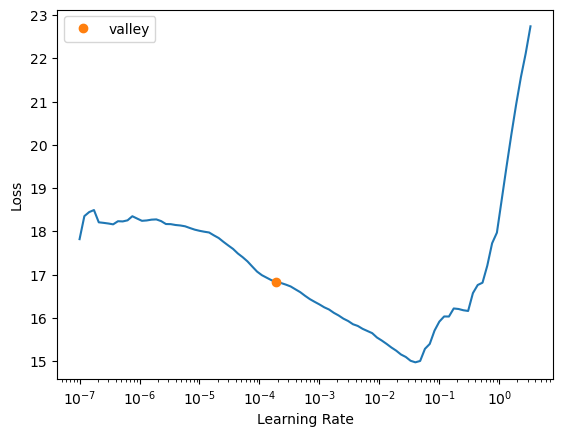

In [27]:
learn.lr_find()

In [28]:
learn.fit_one_cycle(3, 1e-2)
train_res()

,epoch,train_loss,valid_loss,time
0,0,6.911993,7.483701,00:07
1,1,6.505348,6.959623,00:07
2,2,6.245840,6.832403,00:07


In [29]:
test_dl = learn.dls.test_dl(comb_df.iloc[test_idxs])

In [30]:
preds = learn.get_preds(dl=test_dl)

In [31]:
preds

(tensor([[56.5346],
         [41.6132],
         [56.0776],
         ...,
         [70.2647],
         [17.3023],
         [41.1787]]),
 tensor([[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]]))

In [32]:
len(test_df)

2340

In [33]:
len(preds[0])

2340

In [34]:
sample_df['congestion'] = preds[0]

In [36]:
submission = sample_df.to_csv("submission.csv", index=False)

In [37]:
!head submission.csv

row_id,congestion
848835,56.534607
848836,41.613228
848837,56.07761
848838,30.826027
848839,70.3663
848840,64.72091
848841,44.43756
848842,50.788475
848843,63.141586


### Submit Predictions

In [42]:
# if not iskaggle:
#     from kaggle import api
#     api.competition_submit_cli('submission.csv', 'add date_part', comp)

100%|██████████| 37.6k/37.6k [00:00<00:00, 71.3kB/s]


In [39]:
import nbdev
nbdev.export.nb_export('traffic-flow.ipynb', 'app')
print("export successful")

export successful
